In [1]:
import pandas as pd
import matplotlib.pyplot as plot
from sklearn.metrics import mean_squared_error,r2_score

weather = pd.read_csv("weather_data.csv", index_col="DATE")   #importing our data set file
weather = weather.iloc[:12417]                                #since the data sets were repeated 4 times for some reason we only consider the first set (check block 19 for more)

<ipython-input-1-7dd33859935e>:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
weather

,STATION,PRCP,SNWD,TAVG,TMAX,TMIN
DATE,,,,,,
1990-01-01,SPE00120503,12.6,NaN,NaN,15.6,9.4
1990-01-02,SPE00120503,10.8,NaN,NaN,17.0,5.6
1990-01-03,SPE00120503,9.6,NaN,NaN,13.8,6.8
1990-01-04,SPE00120503,0.0,NaN,NaN,12.6,3.6
1990-01-05,SPE00120503,0.0,NaN,NaN,15.6,5.2
...,...,...,...,...,...,...
2023-12-28,SPE00120503,0.0,NaN,NaN,16.4,2.0
2023-12-29,SPE00120503,0.0,NaN,NaN,15.7,7.6
2023-12-30,SPE00120503,0.0,NaN,NaN,18.3,6.8


In [3]:
weather.apply(pd.isnull).sum()/weather.shape[0]              #checking which parameters have null values(1~ 100% of the values are null) 

STATION    0.000000
PRCP       0.000081
SNWD       1.000000
TAVG       1.000000
TMAX       0.000564
TMIN       0.000564
dtype: float64

In [4]:
core_weather = weather[["PRCP", "SNWD", "TAVG", "TMAX", "TMIN"]].copy()
core_weather.columns = ["precip","snwd", "temp_avg", "temp_max", "temp_min"]   #changing the case of column headings since i dont like to type uppercase letters

In [5]:
core_weather.apply(pd.isnull).sum()                                            #checking how many values are null 

precip          1
snwd        12417
temp_avg    12417
temp_max        7
temp_min        7
dtype: int64

In [6]:
del core_weather["snwd"]                                                       #deleting the null columns as they serve no insight into the predictions 

In [7]:
del core_weather["temp_avg"]                                                   #deleting the null columns as they serve no insight into the predictions 

In [8]:
weather

,STATION,PRCP,SNWD,TAVG,TMAX,TMIN
DATE,,,,,,
1990-01-01,SPE00120503,12.6,NaN,NaN,15.6,9.4
1990-01-02,SPE00120503,10.8,NaN,NaN,17.0,5.6
1990-01-03,SPE00120503,9.6,NaN,NaN,13.8,6.8
1990-01-04,SPE00120503,0.0,NaN,NaN,12.6,3.6
1990-01-05,SPE00120503,0.0,NaN,NaN,15.6,5.2
...,...,...,...,...,...,...
2023-12-28,SPE00120503,0.0,NaN,NaN,16.4,2.0
2023-12-29,SPE00120503,0.0,NaN,NaN,15.7,7.6
2023-12-30,SPE00120503,0.0,NaN,NaN,18.3,6.8


In [9]:
core_weather["precip"].value_counts()

precip
0.0     9998
0.1      152
0.2      109
0.3      101
0.8       53
        ... 
21.1       1
41.0       1
26.4       1
28.4       1
17.5       1
Name: count, Length: 337, dtype: int64

In [10]:
#we see that there are a considerate amount of null values in the data and a few NaN values as the data for that day was not recorded so we fill it to 0 as 9998 days had 
#0mm precipitation so it is a safe bet that the other days the precipitation would not have been a lot

In [11]:
core_weather["precip"] = core_weather["precip"].fillna(0)                       #filling precipitation data to 0

In [12]:
core_weather = core_weather.fillna(method="ffill")                              #forward-filling temp_min and temp_max data to 0

<ipython-input-12-cf88904929e7>:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  core_weather = core_weather.fillna(method="ffill")                              #forward-filling temp_min and temp_max data to 0


In [13]:
core_weather.apply(pd.isnull).sum()                                             #checking if we still have any more NaN (null) values

precip      0
temp_max    0
temp_min    0
dtype: int64

In [14]:
core_weather.index                                                              #checking the data-type of the index(DATE)

Index(['1990-01-01', '1990-01-02', '1990-01-03', '1990-01-04', '1990-01-05',
       '1990-01-06', '1990-01-07', '1990-01-08', '1990-01-09', '1990-01-10',
       ...
       '2023-12-23', '2023-12-24', '2023-12-25', '2023-12-26', '2023-12-27',
       '2023-12-28', '2023-12-29', '2023-12-30', '2023-12-31', '2024-01-01'],
      dtype='object', name='DATE', length=12417)

In [15]:
core_weather.index = pd.to_datetime(core_weather.index)                        #since the data-type is object we change it to datetime format

In [16]:
core_weather.index

DatetimeIndex(['1990-01-01', '1990-01-02', '1990-01-03', '1990-01-04',
               '1990-01-05', '1990-01-06', '1990-01-07', '1990-01-08',
               '1990-01-09', '1990-01-10',
               ...
               '2023-12-23', '2023-12-24', '2023-12-25', '2023-12-26',
               '2023-12-27', '2023-12-28', '2023-12-29', '2023-12-30',
               '2023-12-31', '2024-01-01'],
              dtype='datetime64[ns]', name='DATE', length=12417, freq=None)

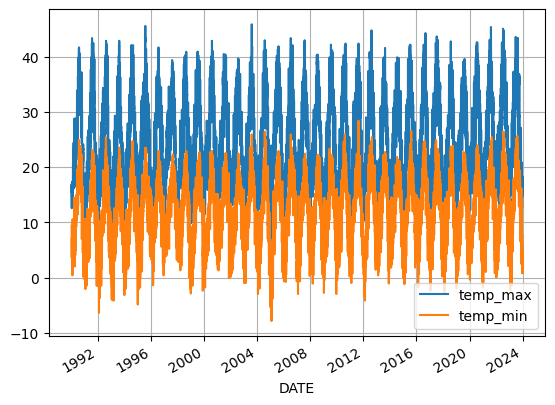

In [17]:
core_weather[["temp_max", "temp_min"]].plot()                                #plotting the max and min temperature to get a rough idea of how the trend has been throughout the dataset
plot.grid(True)

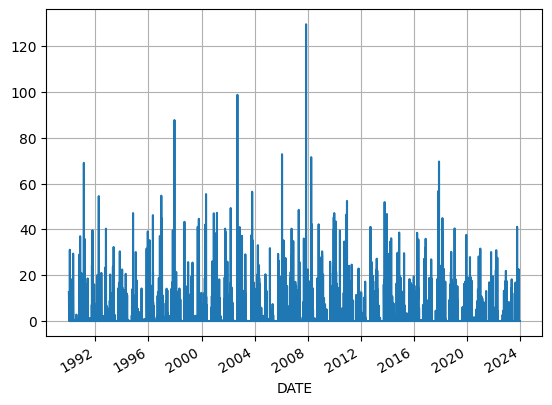

In [18]:
core_weather["precip"].plot()                                               #plotting the precipitation to get a rough idea of how the trend has been throughout the dataset
plot.grid(True)

In [19]:
core_weather.index.year.value_counts().sort_index()                    #as mentioned in block 1, checking if we considered only 1 set out of the 4 that were repeated

DATE
1990    365
1991    365
1992    366
1993    365
1994    365
1995    365
1996    366
1997    365
1998    365
1999    365
2000    366
2001    365
2002    363
2003    365
2004    366
2005    365
2006    365
2007    365
2008    366
2009    365
2010    365
2011    365
2012    366
2013    365
2014    365
2015    365
2016    366
2017    365
2018    365
2019    365
2020    366
2021    365
2022    365
2023    365
2024      1
Name: count, dtype: int64

In [20]:
#Predicting the TMAX values for the year 2023

In [21]:
core_weather["target"] = core_weather.shift(-1)["temp_max"]                      #creating a target column where we put the target values

In [22]:
core_weather

,precip,temp_max,temp_min,target
DATE,,,,
1990-01-01,12.6,15.6,9.4,17.0
1990-01-02,10.8,17.0,5.6,13.8
1990-01-03,9.6,13.8,6.8,12.6
1990-01-04,0.0,12.6,3.6,15.6
1990-01-05,0.0,15.6,5.2,16.8
...,...,...,...,...
2023-12-28,0.0,16.4,2.0,15.7
2023-12-29,0.0,15.7,7.6,18.3
2023-12-30,0.0,18.3,6.8,16.2


In [23]:
core_weather = core_weather.iloc[:-1,:].copy()                                   #since the last value is null, we eliminate it

In [24]:
core_weather

,precip,temp_max,temp_min,target
DATE,,,,
1990-01-01,12.6,15.6,9.4,17.0
1990-01-02,10.8,17.0,5.6,13.8
1990-01-03,9.6,13.8,6.8,12.6
1990-01-04,0.0,12.6,3.6,15.6
1990-01-05,0.0,15.6,5.2,16.8
...,...,...,...,...
2023-12-27,0.0,15.2,1.3,16.4
2023-12-28,0.0,16.4,2.0,15.7
2023-12-29,0.0,15.7,7.6,18.3


In [25]:
from sklearn.linear_model import Ridge                                       #we import ridge regression model as that is what we would be using it for our prediction

reg = Ridge(alpha=.1)

In [26]:
predictors = ["precip", "temp_max", "temp_min"]                              #we choose our parameters that would help in the prediction of the future values

In [27]:
train = core_weather.loc[:"2022-12-31"]                                      #training our machine based on the data until 31.12.2022
test = core_weather.loc["2023-01-01":]                                       #testing our machine for the data 01.01.2023 onwards

In [28]:
reg.fit(train[predictors], train["target"])                                  #training our target based on the feature vectors(predictors)

Ridge(alpha=0.1)

In [29]:
#the 0.1 value of apha shows that the model penalises the very large coefficients(errors) slightly to avoid overfitting

In [30]:
predictions = reg.predict(test[predictors])                                   #making the predictions on our test data based on our feature vectors(predictors)

In [31]:
mean_squared_error(test["target"], predictions)                               #getting the mean score error on our predictions (the smaller the better)

5.422379640941639

In [32]:
r2_score(test["target"], predictions)                                         #getting the r² error on our predictions (closer to 1 is good)

0.9204701746975413

In [33]:
combined = pd.concat([test["target"], pd.Series(predictions, index=test.index)], axis=1)
combined.columns = ["actual", "predictions"]                                  #combining and presenting our predictions side by side to our actual data
combined

,actual,predictions
DATE,,
2023-01-01,16.0,19.901449
2023-01-02,15.7,16.932279
2023-01-03,20.4,16.829492
2023-01-04,19.1,20.475689
2023-01-05,17.9,19.303968
...,...,...
2023-12-27,16.4,15.431306
2023-12-28,15.7,16.554908
2023-12-29,18.3,16.496137


<AxesSubplot:xlabel='DATE'>

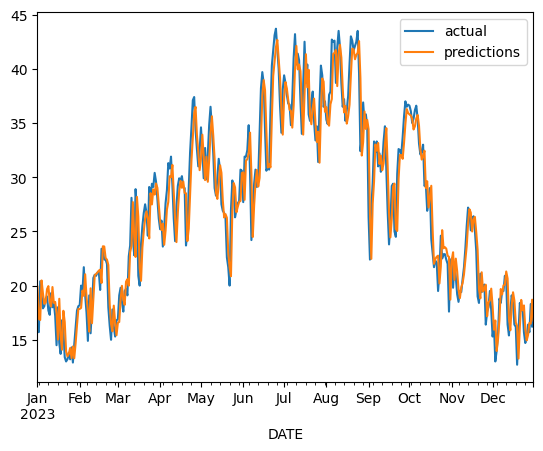

In [34]:
combined.plot()                                                                #plotting the two values for the year 2023

In [35]:
reg.coef_ #-0.04164915 ~ the precipitation values negatively affect the maximum temperature by a huge margin. z.B. more rain implies the maximum temperature will be lower than expected the next day

array([-0.04285262,  0.87840653,  0.09930606])

In [36]:
#Predicting the TMIN values for the year 2023

In [37]:
#Predicting the TMIN values for the year 2023

In [38]:
core_weather["target"] = core_weather.shift(-1)["temp_min"]                      #creating a target column where we put the target values
core_weather = core_weather.iloc[:-1,:].copy()                                   #since the last value is null, we eliminate it

In [39]:
core_weather

,precip,temp_max,temp_min,target
DATE,,,,
1990-01-01,12.6,15.6,9.4,5.6
1990-01-02,10.8,17.0,5.6,6.8
1990-01-03,9.6,13.8,6.8,3.6
1990-01-04,0.0,12.6,3.6,5.2
1990-01-05,0.0,15.6,5.2,7.2
...,...,...,...,...
2023-12-26,0.0,14.7,0.8,1.3
2023-12-27,0.0,15.2,1.3,2.0
2023-12-28,0.0,16.4,2.0,7.6


In [40]:
from sklearn.linear_model import Ridge                                       #we import ridge regression model as that is what we would be using it for our prediction

reg = Ridge(alpha=.1)

In [41]:
predictors = ["precip", "temp_max", "temp_min"]                              #we choose our parameters that would help in the prediction of the future values

In [42]:
train = core_weather.loc[:"2022-12-31"]                                      #training our machine based on the data until 31.12.2022
test = core_weather.loc["2023-01-01":]                                       #testing our machine for the data 01.01.2023 onwards

In [43]:
reg.fit(train[predictors], train["target"])                                  #training our target based on the feature vectors(predictors)

Ridge(alpha=0.1)

In [44]:
#the 0.1 value of apha shows that the model penalises the very large coefficients(errors) slightly to avoid overfitting

In [45]:
predictions = reg.predict(test[predictors])                                   #making the predictions on our test data based on our feature vectors(predictors)

In [46]:
mean_squared_error(test["target"], predictions)                               #getting the mean score error on our predictions (the smaller the better)

4.604195792274621

In [47]:
r2_score(test["target"], predictions)                                         #getting the r² error on our predictions (closer to 1 is good)

0.8849971845567766

In [48]:
combined = pd.concat([test["target"], pd.Series(predictions, index=test.index)], axis=1)
combined.columns = ["actual", "predictions"]                                  #combining and presenting our predictions side by side to our actual data
combined

,actual,predictions
DATE,,
2023-01-01,12.1,7.859347
2023-01-02,11.0,9.934465
2023-01-03,6.1,8.796157
2023-01-04,5.8,6.824134
2023-01-05,6.5,6.302572
...,...,...
2023-12-26,1.3,1.972558
2023-12-27,2.0,2.420719
2023-12-28,7.6,3.174478


<AxesSubplot:xlabel='DATE'>

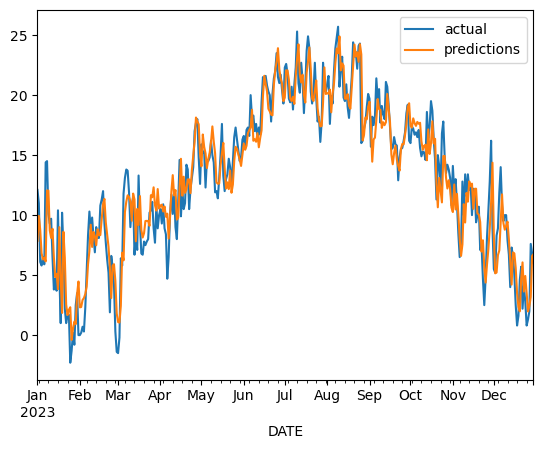

In [49]:
combined.plot()                                                                #plotting the two values for the year 2023

In [50]:
reg.coef_ #0.05638197 ~ the precipitation values directly affect the minimum temperature by a not so huge margin. z.B. more rain implies the minimum temperature will be very slightly lower than expected the next day

array([0.05626742, 0.25266516, 0.64365762])